# Generating sequences by kinetic Monte-Carlo

Imports

In [1]:
import importlib
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
import pyBigWig

from Modules import utils, plot_utils

2023-03-21 16:51:20.537604: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Functions from MyModuleLibrary

In [3]:
def correlate(y_true, y_pred):
    """
		Calculate the correlation between the predictions and the labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = correlate)
		>>> load_model('file', custom_objects = {'correlate : correlate})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    return sigma_XY/(sigma_X*sigma_Y + K.epsilon())

def mae_cor(y_true, y_pred):
    """
	   Calculate the mean absolute error minus the correlation between
        predictions and  labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = mae_cor)
		>>> load_model('file', custom_objects = {'mae_cor : mae_cor})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))
    
    return 1 + mae - cor

def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):  
    """ 
        Take a numpy array and return a view of this array after applying a rolling window.

        This takes a numpy and cut it in several pieces with the size, the stride and the 
        axes asked as needed. You may want to use it in order to create a set of sequences
        from an array.

        :param array: The array we want to cut
        :param window: The length of the window
        :param asteps: The stride between two window applied
        :param wsteps: The stride whitin the window
        :param axes: The axe on which to apply the rolling window
        :param toend: Weither or not to finish the cut
        :type array: numpy array
        :type window: int or tuple
        :type asteps: int or tuple
        :type wsteps: int or tuple
        :type axes: int
        :type toend: boolean
        :return: The view of the array
        :rtype: numpy array

        :Example:

        >>> a = numpy.array([0,1,2,3,4,5])
        >>> rolling_window(a, window = 2, asteps = 2, wsteps = None)
        array([[0,1],
               [2,3],
               [4,5]])
        >>> rolling_window(a, window = 2, asteps = None, wsteps = 2)
        array([[0,2],
               [1,3],
               [2,4]
               [3,5]])
        >>> rolling_window(a, window = 5, asteps = 2, wsteps = None)
        array([[0,1,2,3,4]])

        .. warning:: Be carreful about the combination of window, wsteps and asteps that may raise 
                     ValueError. This function forces the window to be of the asked size and thus 
                     may stop the application of the window before the end.
    """        

    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger than 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger than the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any \"old\" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtypenucleotid=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

def predict(one_hot_chr, model, annotation_type, last_window=False):
    if annotation_type == 'nucleosome':
        WINDOW = 2001
        X = rolling_window(one_hot_chr, window=(WINDOW, 4))[:, 0, :, None,  :]
        pred = np.zeros(len(one_hot_chr))
        pred[WINDOW//2:-(WINDOW//2)] = model.predict(X)[:, 0]
    else:
        if annotation_type == 'cohesine':
            WINDOW = 32768
        elif annotation_type == 'pol':
            WINDOW = 2048
        else:
            raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
        X = rolling_window(one_hot_chr, window=(WINDOW, 4), asteps=(WINDOW, 4))[:, 0, :, :]
        print(X.shape)
        pred = np.zeros((len(one_hot_chr),))
        y = model.predict(X)
        y = np.repeat(y.ravel(), 128)
        pred[:len(y)] = y
        if last_window:
            X = one_hot_chr[-WINDOW:].reshape((1, WINDOW, 4))
            y = model.predict(X)
            y = np.repeat(y.ravel(), 128)
            leftover = len(pred) % WINDOW
            pred[-leftover:] = y[-leftover:]
    return pred


Generate random sequences

In [140]:
species = 'SCerevisiae'
annotation_type = 'nucleosome'
if annotation_type == 'nucleosome':
    order = 'ATGC'
    seq_length = 2001
    model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5')
    model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
else:
    order = 'ACGT'

n_seqs = 1000
n_gcs = 21
gcs = np.linspace(0, 1, n_gcs)
seqs = []
for gc in gcs:
    p = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]
    seqs.append(np.random.choice(['A', 'C', 'G', 'T'], (n_seqs, seq_length), p=p))
seqs = np.concatenate(seqs)
one_hots = utils.one_hot_encoding(seqs, read_length=seq_length, one_hot_type=int, order=order).reshape(-1, seq_length, 4)
if annotation_type == 'nucleosome':
    one_hots = one_hots.reshape(-1, seq_length, 1, 4)
preds = model.predict(one_hots).reshape((n_gcs, n_seqs))
del model
np.save(Path(model_file.parent, f'preds_{model_file.stem}_randomGC_indep_1000.npy'), preds)

In [141]:
species = 'SCerevisiae'
annotation_type = 'nucleosome'
if annotation_type == 'nucleosome':
    order = 'ATGC'
    WINDOW = 2001
    model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5')
    model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
else:
    order = 'ACGT'

n_seqs = 1000
seq_length = (WINDOW // 2)*2 + n_seqs
n_gcs = 21
gcs = np.linspace(0, 1, n_gcs)
preds = []
for gc in gcs:
    p = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]
    seq = np.random.choice(['A', 'C', 'G', 'T'], seq_length, p=p)
    one_hot = utils.one_hot_encode(seq, one_hot_type=int, order=order)
    X = rolling_window(one_hot, window=(WINDOW, 4))[:, 0, :, None,  :]
    preds.append(model.predict(X)[:, 0])#.reshape((n_gcs, n_seqs))
del model
preds = np.array(preds)
preds.shape
np.save(Path(model_file.parent, f'preds_{model_file.stem}_randomGC_1000.npy'), preds)

In [8]:
preds_indep = np.load(Path(data_dir, species, 'models_etienne', f'preds_weights_myco_rep1_randomGC_indep_1000.npy'))
preds = np.load(Path(data_dir, species, 'models_etienne', f'preds_weights_myco_rep1_randomGC_1000.npy'))

In [165]:
pred_etienne = np.load(Path(data_dir, species, 'results', 'etienne_nucleosome_pneu_rep1_chr16.npy'))
pred_etienne.mean()

0.20888963985647246

In [57]:
all_preds = {}
with np.load(Path(data_dir, species, 'results', 'preds_weights_myco_rep1_on_W303.npz')) as f:
    for chr_id in f.keys():
        all_preds[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'preds_weights_myco_rep1_on_Mmm_Linear_740kb.npz')) as f:
    all_preds['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'preds_weights_pneu_rep1_on_Pneu300.npz')) as f:
    all_preds['pneu'] = f['chr1']

In [7]:
bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM_myco265.bw')
labels = {}
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr' or chr_id[-3:] == '.fa':
        labels[chr_id] = bw.values(chr_id, 0, -1, numpy=True)
bw.close()

In [8]:
thres = sum([v.sum() for v in labels.values()]) / 1e6
print(thres)
norm_labels = {}
for chr_id, lab in labels.items():
    norm_labels[chr_id] = lab / thres
norm_myco = norm_labels['Mmm_Linear_740kb.fa']
norm_yeast = np.concatenate([v for k, v in norm_labels.items() if k[:3]=='chr'])
print('myco', norm_myco.mean(), norm_myco.std())
print('yeast', norm_yeast.mean(), norm_yeast.std())

591.026041
myco 0.014953886 0.04790398
yeast 0.07983067 0.21724695


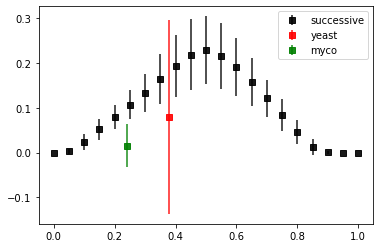

In [16]:
n_gcs = 21
gcs = np.linspace(0, 1, n_gcs)
plt.errorbar(gcs, y=preds_indep.mean(axis=1), yerr=preds_indep.std(axis=1), fmt='ks', alpha=0.9, label='successive')
# plt.errorbar(gcs, y=preds.mean(axis=1), yerr=preds.std(axis=1), fmt='bs', alpha=0.9, label='independent')
plt.errorbar([0.38], y=[norm_yeast.mean()], yerr=[norm_yeast.std()], fmt='rs', alpha=0.9, label='yeast')
plt.errorbar([0.24], y=[norm_myco.mean()], yerr=[norm_myco.std()], fmt='gs', alpha=0.9, label='myco')
plt.legend()

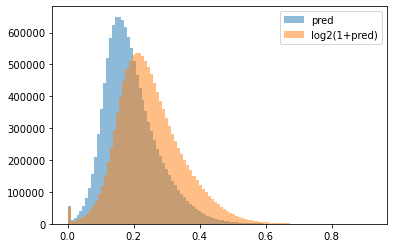

In [36]:
merge_labels = np.concatenate([v for k, v in norm_labels.items() if k[:3]=='chr'])
merge_preds = np.concatenate([v for k, v in all_preds.items() if k[:3]=='chr'])
# plt.hist(np.log2(1 + merge_labels), bins=100, range=(0, 1), label='exp')
plt.hist(merge_preds, bins=100, label='pred', alpha=0.5)
plt.hist(np.log2(1 + merge_preds), bins=100, label='log2(1+pred)', alpha=0.5)
plt.legend()
# plt.yscale('log')
plt.show()
plt.close()

In [58]:
def sliding_GC(one_hot, order='ATGC'):
    valid_mask = one_hot.sum(axis=1) != 0
    GC_idx = [order.find('G'), order.find('C')]
    GC_mask = one_hot[:,GC_idx].sum(axis=1)
    return utils.moving_sum(GC_mask, n=2001) / utils.moving_sum(valid_mask, n=2001)

species = 'SCerevisiae'
genome = 'W303'
order = 'ATCG'
window_gc = {}
with np.load(Path(data_dir, species, 'genome', genome, 'W303_ATGC.npz')) as f:
    for chr_id in f.keys():
        window_gc[chr_id] = sliding_GC(f[chr_id])

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb_ATGC.npz')) as f:
    window_gc['myco'] = sliding_GC(f['chr1'])

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300_ATGC.npz')) as f:
    window_gc['pneu'] = sliding_GC(f['chr1'])

In [108]:
all_preds = {}
with np.load(Path(data_dir, species, 'results', 'preds_weights_myco_rep1_on_W303.npz')) as f:
    for chr_id in f.keys():
        all_preds[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'preds_weights_myco_rep1_on_Mmm_Linear_740kb.npz')) as f:
    all_preds['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'preds_weights_pneu_rep1_on_Pneu300.npz')) as f:
    all_preds['pneu'] = f['chr1']

In [109]:
window_gc_yeast = np.concatenate([v for k, v in window_gc.items() if k[:3]=='chr'])
all_preds_yeast = np.concatenate([v[1000:-1000] for k, v in all_preds.items() if k[:3]=='chr'])

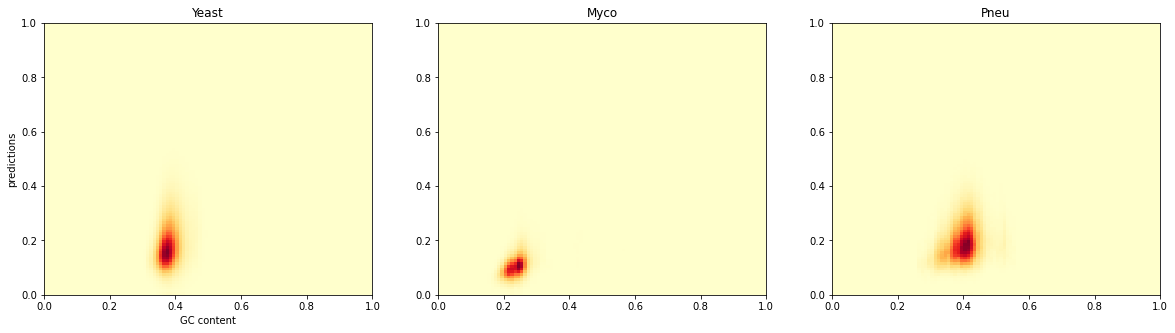

In [107]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(131)
ax.set_title('Yeast')
ax.hist2d(window_gc_yeast, all_preds_yeast, bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax2 = plt.subplot(132)
ax2.set_title('Myco')
ax2.hist2d(window_gc['myco'], all_preds['myco'][1000:-1000], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax3 = plt.subplot(133)
ax3.set_title('Pneu')
ax3.hist2d(window_gc['pneu'], all_preds['pneu'][1000:-1000], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax.set_ylabel('predictions')
ax.set_xlabel('GC content')
plt.show()
plt.close()

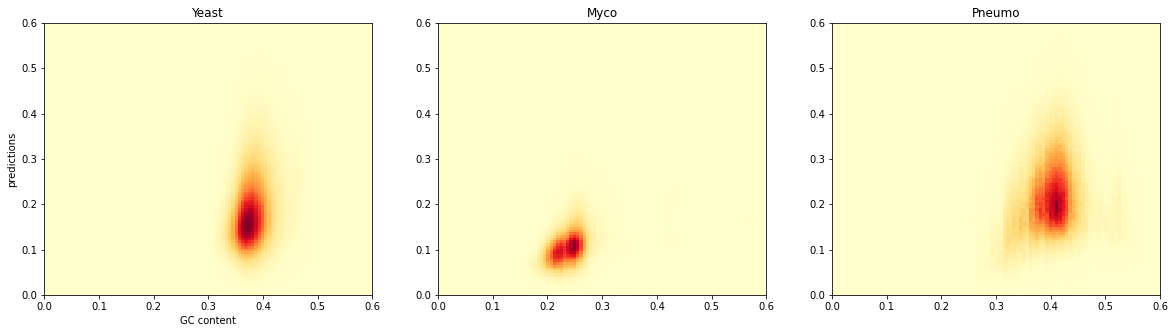

In [137]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(131)
ax.set_title('Yeast')
ax.hist2d(window_gc_yeast, all_preds_yeast, bins=100, range=((0, 0.6), (0, 0.6)), cmap='YlOrRd')

ax2 = plt.subplot(132)
ax2.set_title('Myco')
ax2.hist2d(window_gc['myco'], all_preds['myco'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap='YlOrRd')

ax3 = plt.subplot(133)
ax3.set_title('Pneumo')
ax3.hist2d(window_gc['pneu'], all_preds['pneu'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap='YlOrRd')

ax.set_ylabel('predictions')
ax.set_xlabel('GC content')
plt.show()
plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


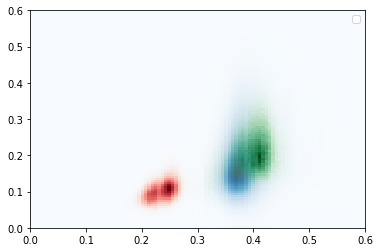

In [140]:
red = plt.cm.Reds
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = mpl.colors.ListedColormap(fading_red)
green = plt.cm.Greens
fading_green = green(np.arange(green.N)) # extract colors
fading_green[:, -1] = np.linspace(0, 1, green.N) # modify alpha
fading_green = mpl.colors.ListedColormap(fading_green)
plt.hist2d(window_gc_yeast, all_preds_yeast, bins=100, range=((0, 0.6), (0, 0.6)), cmap='Blues', label='yeast')
plt.hist2d(window_gc['myco'], all_preds['myco'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap=fading_red, label='myco')
plt.hist2d(window_gc['pneu'], all_preds['pneu'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap=fading_green, label='pneumo')
plt.legend()
plt.show()
plt.close()

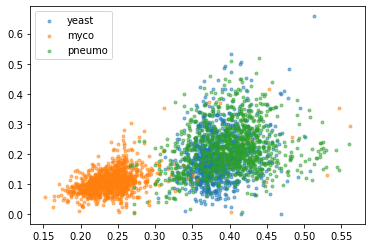

In [139]:
sample = np.random.choice(len(window_gc_yeast), size=1_000, replace=False)
plt.scatter(window_gc_yeast[sample], all_preds_yeast[sample], marker='.', alpha=0.5, label='yeast')
sample = np.random.choice(len(window_gc['myco']), size=1_000, replace=False)
plt.scatter(window_gc['myco'][sample], all_preds['myco'][1000:-1000][sample], marker='.', alpha=0.5, label='myco')
sample = np.random.choice(len(window_gc['pneu']), size=1_000, replace=False)
plt.scatter(window_gc['pneu'][sample], all_preds['pneu'][1000:-1000][sample], marker='.', alpha=0.5, label='pneumo')
plt.legend()
plt.show()
plt.close()


#### Load models

Load chromosome

In [15]:
species = 'SCerevisiae'
genome = 'W303'
chr_id = 'chr16'
with np.load(Path(data_dir, species, 'genome', genome, 'W303_ATGC.npz')) as f:
    one_hot_chr_ref_ATGC = f[chr_id]
with np.load(Path(data_dir, species, 'genome', genome, 'W303.npz')) as f:
    one_hot_chr_ref_ACGT = f[chr_id]
# reverse = one_hot_chr[::-1,::-1]
one_hot_chr_ref_ACGT.shape

(986200, 4)

In [12]:
pred_nucleosome_etienne = np.load(Path(data_dir, species, 'results', 'etienne_nucleosome_pneu_rep1_chr16.npy'))

In [51]:
species = 'SCerevisiae'
genome = 'bacterie'
model_nucleosome = tf.keras.models.load_model(f'{data_dir}/{species}/models_etienne/weights_myco_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
all_preds = {}
with np.load(Path(data_dir, species, 'genome', genome, 'Pneu300_ATGC.npz')) as f:
    for chr_id in f.keys():
        one_hot_chr_ref_ATGC = f[chr_id]
        all_preds[chr_id] = predict(one_hot_chr_ref_ATGC, model_nucleosome, "nucleosome")
del model_nucleosome
np.savez(Path(data_dir, species, 'results', 'preds_weights_myco_rep1_on_Pneu300.npz'), **all_preds)

2023-03-21 17:44:12.354216: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 6530831784 exceeds 10% of free system memory.


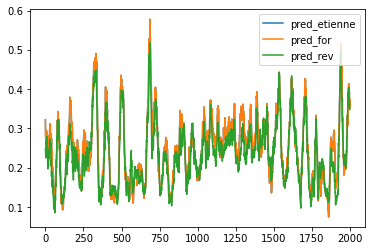

In [24]:
start = 1000
stop = start + 2000
plt.plot(pred_nucleosome_etienne[start:stop], label='pred_etienne')
plt.plot(pred_nucleosome[start:stop], label='pred_for')
plt.plot(pred_nucleosome_rev[start:stop], label='pred_rev')
plt.legend()
plt.show()
plt.close()

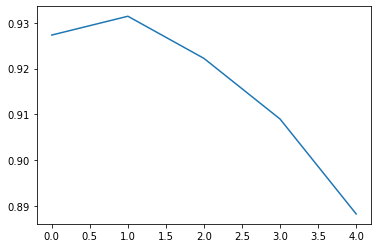

In [8]:
corrs = [pearsonr(pred_nucleosome, pred_nucleosome_rev)[0]]
for offset in range(1, 5):
    corrs.append(pearsonr(pred_nucleosome[offset:], pred_nucleosome_rev[:-offset])[0])
plt.plot(np.arange(len(corrs)), corrs)
plt.show()
plt.close()

In [122]:
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC100.npz')) as f:
    for k in f.keys():
        one_hot_chr_ACGT = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC100_ATGC.npz')) as f:
    for k in f.keys():
        one_hot_chr_ATGC = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC_UAS_TATA-yeGFP-NLS.npz')) as f:
    for k in f.keys():
        one_hot_chr2_ACGT = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC_UAS_TATA-yeGFP-NLS_ATGC.npz')) as f:
    for k in f.keys():
        one_hot_chr2_ATGC = f[k]
        break
one_hot_chr2_ACGT.shape

(125243, 4)

In [169]:
seq = utils.one_hot_decode(one_hot_chr_ACGT)
seq2 = utils.one_hot_decode(one_hot_chr2_ACGT)
ref = utils.one_hot_decode(one_hot_chr_ref_ACGT)

In [225]:
start = 3623
size = 15_045 - start
for i in range(len(ref) - size + 1):
    if seq2[start:start+size] == ref[i:i+size]:
        print(i)

836753


In [262]:
pos = 833_130
start = 65_020
offset = -8625
length = 100
# print(ref[pos+start : pos+start+length])
print(seq[start:start+length])
print(seq2[start+offset:start+offset+length])

CTGTATAAACCAGCGCCACAGAATAGAACCCACTGTACGAGTGATCTGGGTACGGCACTCGGAGCGTAGTAATGGACACCACACATTTCTGGAACCTTTG
CTGTATAAACCAGCGCCACAGAATAGAACCCACTGTACGAGTGATCTGGGTACGGCACTCGGAGCGTAGTAATGGACACCACACATTTCTGGAACCTTTG


In [240]:
i = 68852
while seq[-i-1] == seq2[-i-2]:
    i += 1
print(i)

68852


In [132]:
data = 'SCerevisiae'

model_nucleosome = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
pred_nucleosome = predict(one_hot_chr_ATGC, model_nucleosome, "nucleosome")
pred_nucleosome2 = predict(one_hot_chr2_ATGC, model_nucleosome, "nucleosome")
del model_nucleosome
# model_nucleosome2 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_nucleosome_myco_rep2.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome2 = predict(one_hot_chr_ATGC, model_nucleosome2, "nucleosome")
# del model_nucleosome2
# model_nucleosome3 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_nucleosome_myco_rep3.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome3 = predict(one_hot_chr_ATGC, model_nucleosome3, "nucleosome")
# del model_nucleosome3
# model_nucleosome_pneu = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_pneu_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome_pneu = predict(one_hot_chr_ATGC, model_nucleosome_pneu, "nucleosome")
# del model_nucleosome_pneu
# model_nucleosome_all = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_CNN_nucleosome_in_vivo_all_data.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome_all = predict(one_hot_chr_ATGC, model_nucleosome_all, "nucleosome")
# del model_nucleosome_all

model_cohesine = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_rep1_cohesine.hdf5', custom_objects={'correlate': correlate})
pred_cohesine = predict(one_hot_chr_ACGT, model_cohesine, "cohesine", last_window=True)
pred_cohesine2 = predict(one_hot_chr2_ACGT, model_cohesine, "cohesine", last_window=True)
del model_cohesine

model_pol = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_pol2_2048_16.hdf5', custom_objects={'correlate' : correlate})
pred_pol = predict(one_hot_chr_ACGT, model_pol, "pol", last_window=True)
pred_pol2 = predict(one_hot_chr2_ACGT, model_pol, "pol", last_window=True)
del model_pol

In [133]:
df = pd.DataFrame({
    'nucleosome': pred_nucleosome,
    'cohesine': pred_cohesine,
    'pol2': pred_pol})
df2 = pd.DataFrame({
    'nucleosome': pred_nucleosome2,
    'cohesine': pred_cohesine2,
    'pol2': pred_pol2})

In [136]:
df.to_csv('../shared_folder/SCerevisiae/results/preds_chr4_SynEC100_full.csv')
df2.to_csv('../shared_folder/SCerevisiae/results/preds_chr4_SynEC_UAS_TATA-yeGFP-NLS_full.csv')

In [264]:
preds = {}
for file in Path('..', 'shared_folder', 'SCerevisiae', 'models').glob('*.hdf5'):
    requires_mae_cor = False
    pred = None
    try:
        model = tf.keras.models.load_model(file, custom_objects={'correlate': correlate})
    except:
        model = tf.keras.models.load_model(file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
        requires_mae_cor = True
    try:
        pred = predict(one_hot_chr_ref_ACGT, model, "cohesine")
        annotation_type = "cohesine"
    except:
        try:
            pred = predict(one_hot_chr_ref_ACGT, model, "pol")
            annotation_type = "pol"
        except:
            try:
                pred = predict(one_hot_chr_ref_ATGC, model, "nucleosome")
                annotation_type = "nucleosome"
            except:
                annotation_type = None        
    del model
    preds[file] = pred
    print(file, requires_mae_cor, annotation_type)
    # if pred is not None:
    #     start = 54_000
    #     stop = 59_000
    #     fig, ax = plt.subplots(figsize=(15, 3))
    #     ax.plot(np.arange(start, stop), pred[start:stop], linewidth=0.2)
    #     ax.set_ylim(0, 3)
    #     ax.fill_between(np.arange(start, stop), pred[start:stop], 0)
    

../shared_folder/SCerevisiae/models/weights_myco_rep1_cohesine_3.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2_2048_16_2.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_gal_pol2_2048_16.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_CNN_nucleosome_in_vivo_all_data.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_Bassenji_32768_256.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_pneu_rep1_transcription.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_nucleosome_myco_rep3.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_myco_rep1_cohesine_2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2_2048_16_3.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_pneu_rep1_cohesine_2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_gal_pol2.hdf5 False cohesine
../shared

Predict

In [192]:
smooth_pred_nucleosome = utils.smooth(pred_nucleosome, 201, mode='gaussian', sigma=10)

In [9]:
pred_nucleosome_etienne = np.load(Path(data_dir, data, 'results', 'etienne_nucleosome_pneu_rep1_chr16.npy'))
pred_nucleosome_etienne.shape # 986200
# preds_etienne[-1010:-990]

(986200,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


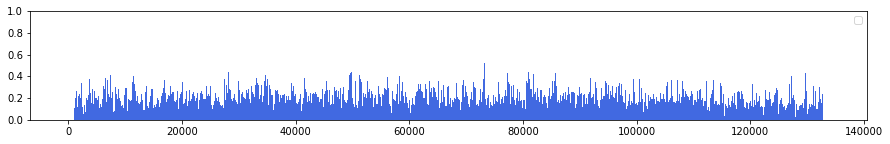

In [48]:
start = 0 #210_000
end = len(df) #220_000
plt.figure(figsize=(15, 4))
# plt.bar(np.arange(start, end), height=pred_nucleosome[start:end], width=1, alpha=1, color=(0, 0, 1), label='pred_myco')
plt.bar(np.arange(start, end), height=df['nucleosome'], width=1, color='royalblue')
# plt.bar(np.arange(start, end), height=pred_nucleosome_etienne[start:end], width=1, alpha=0.3, color=(0, 1, 0), label='pred_etienne')
plt.ylim(0, 1)
plt.legend()
plt.show()
plt.close()

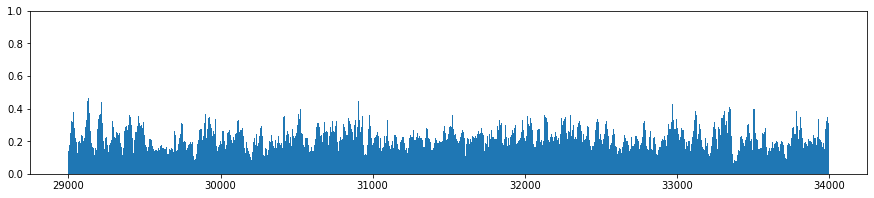

In [181]:
start = 29_000
stop = 34_000
plt.figure(figsize=(15, 3))
plt.bar(np.arange(start, stop), height=df['nucleosome'][start:stop], width=1)
plt.ylim(0, 1)
plt.show()
plt.close()

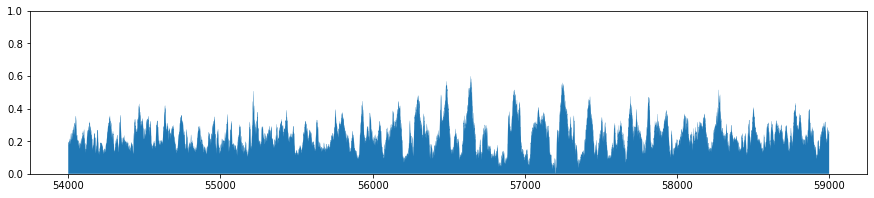

In [185]:
start = 54_000
stop = 59_000
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(np.arange(start, stop), df['nucleosome'][start:stop], linewidth=0.2)
ax.set_ylim(0, 1)
ax.fill_between(np.arange(start, stop), df['nucleosome'][start:stop], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/pred_chr4_SynEC100_nucleosome_zoom', bbox_inches='tight')

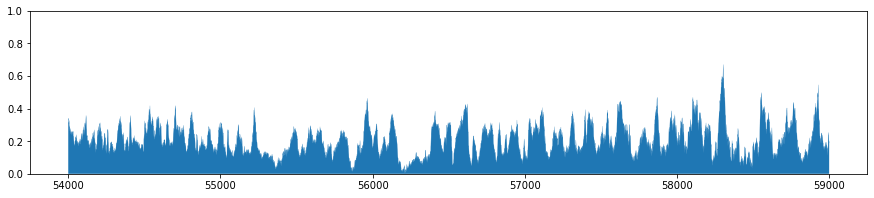

In [186]:
start = 54_000
stop = 59_000
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(np.arange(start, stop), df2['nucleosome'][start:stop], linewidth=0.2)
ax.set_ylim(0, 1)
ax.fill_between(np.arange(start, stop), df2['nucleosome'][start:stop], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/pred_chr4_SynEC_UAS_TATA-yeGFP-NLS_nucleosome_zoom', bbox_inches='tight')

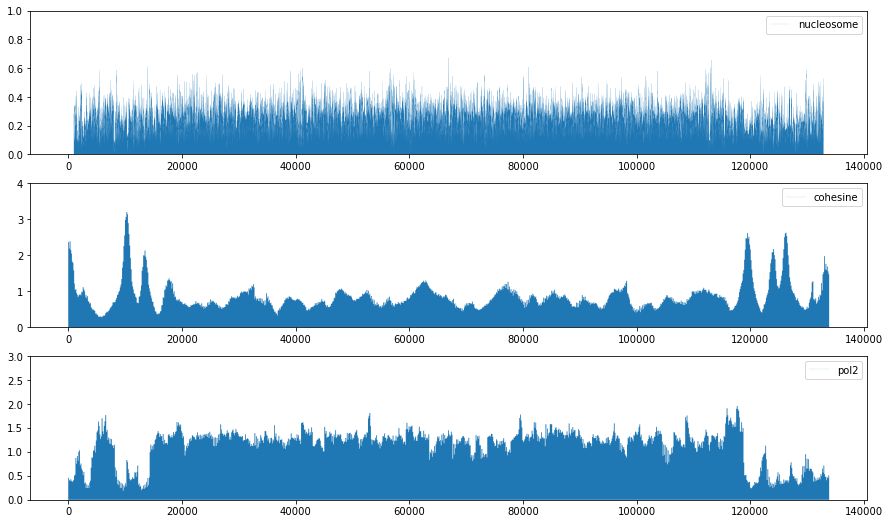

In [135]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 9))
df.plot(y='nucleosome', use_index=True, ylim=(0, 1), ax=axes[0], linewidth=0.1)
axes[0].fill_between(df.index, df['nucleosome'], 0)
df.plot(y='cohesine', use_index=True, ylim=(0, 4), ax=axes[1], linewidth=0.1)
axes[1].fill_between(df.index, df['cohesine'], 0)
df.plot(y='pol2', use_index=True, ylim=(0, 3), ax=axes[2], linewidth=0.1)
axes[2].fill_between(df.index, df['pol2'], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/preds_chr4_SynEC100_full', bbox_inches='tight')

(0.9999999999998332, 0.0)


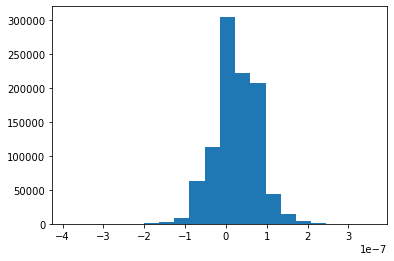

In [20]:
print(pearsonr(pred_nucleosome_pneu, pred_nucleosome_etienne))
diffs = pred_nucleosome_pneu - pred_nucleosome_etienne
plt.hist(diffs, bins=20)
plt.show()
plt.close()

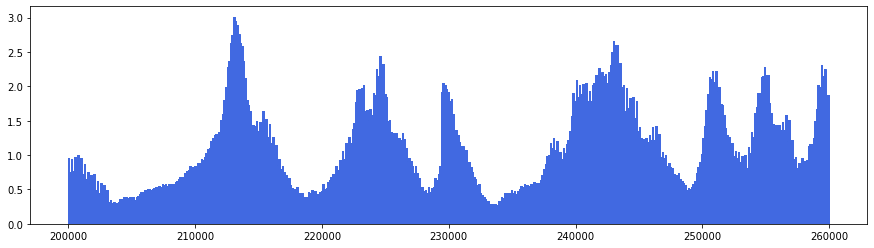

In [35]:
start = 200_000
end = 260_000
plt.figure(figsize=(15, 4))
plt.bar(np.arange(start, end), height=pred_cohesine[start:end], width=1, edgecolor='royalblue')
plt.show()
plt.close()

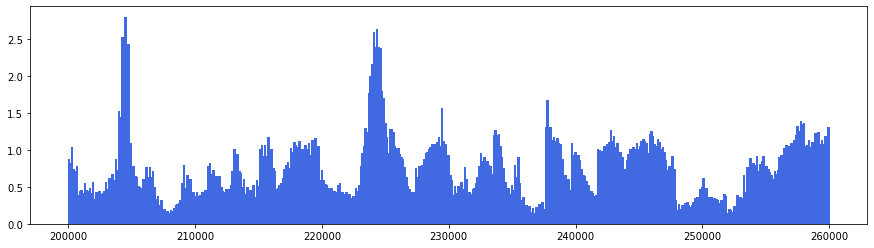

In [32]:
start = 200_000
end = 260_000
plt.figure(figsize=(15, 4))
plt.bar(np.arange(start, end), height=pred_pol[start:end], width=1, edgecolor='royalblue')
plt.show()
plt.close()

## Kinetic Monte Carlo

In [ ]:
# initialisation :
# use ATGC content from SCerevisiae
# build 1000 sequences of length N
# mutation and selection: 
# make every 3*N single nucleotide mutation
# selection probability of 1/norm * exp(-delta_energy / T)
# 10**4 steps
# save each configuration and keep best
# energy :
# create a 2001 + N sequence repeating the length N sequence, centered on it
# distance to target density E_reg is d(x, y) = 1 - corr(x, y) + 1/N * sum(abs(x_i - y_i))
# GC content constraint E_GC is abs(GC_synt - GC_nat) GC_nat=0.38
# E_mut penalizes sequences already seen
# E_rev, like E_reg but on reverse strand
# total energy is exp(-(a*E_GC + b*E_reg + c*E_rev + d*E_mut)/T)

In [5]:
SCer_GC = 0.38
SCer_p = [0.31, 0.19, 0.19, 0.31]

In [12]:
SCer_GC = 0.38
SCer_p = [0.31, 0.19, 0.19, 0.31]
n_seqs = 6
seq_length = 5
seqs1 = np.random.choice(['A', 'C', 'G', 'T'], (n_seqs, seq_length), p=SCer_p)
one_hots1 = utils.one_hot_encoding(seqs1, read_length=seq_length, one_hot_type=int).reshape(n_seqs, seq_length, 4)
seqs2 = np.random.choice(['A', 'C', 'G', 'T'], (n_seqs, seq_length), p=SCer_p)
one_hots2 = utils.one_hot_encoding(seqs2, read_length=seq_length, one_hot_type=int).reshape(n_seqs, seq_length, 4)

In [237]:
from Modules import models
importlib.reload(models)
model = models.build_model('inception_dna_paired_v1')

In [240]:
model.predict([one_hots1, one_hots2])

array([[0.68842316],
       [0.62810767],
       [0.5163134 ],
       [0.56415707]], dtype=float32)

In [28]:
one_hots.shape

(2, 3, 1, 4)

In [29]:
mult = np.ones([1, 1]).reshape(1, 1, 1, 1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)